<center><h1>Sen_Pang_HW1</h1></center>
<center><h4>Name: senpang </h4></center>
<center><h4>GitHub Username: senpang-coder</h4></center>
<center><h4>USC ID: 8598139533</h4></center>
<br>

<center><font size="4">Vertebral Column Data</font></center>

### (a) Download Data

Package imports

In [134]:
from numpy.linalg import inv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import zipfile
import requests  
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, precision_score, f1_score
from collections import Counter

Get the Vertebral Column Data Set

Download the dataset from UCI and convert it into a usable DataFrame. Add column names, and check the data.

In [46]:
zip_url = "https://archive.ics.uci.edu/static/public/212/vertebral%2Bcolumn.zip"
resp = requests.get(zip_url, timeout=60)
resp.raise_for_status() 

with zipfile.ZipFile(io.BytesIO(resp.content)) as zf:
    with zf.open("column_2C.dat") as f2c:
        data_2c = pd.read_csv(f2c, sep=r"\s+", header=None)
    with zf.open("column_3C.dat") as f3c:
        data_3c = pd.read_csv(f3c, sep=r"\s+", header=None)

cols = [
    "pelvic_incidence",         
    "pelvic_tilt",              
    "lumbar_lordosis_angle",    
    "sacral_slope",             
    "pelvic_radius",            
    "degree_spondylolisthesis", 
    "class"                    
]
data_2c.columns = cols

data_3c.columns = cols


print("2C shape:", data_2c.shape)
print("3C shape:", data_3c.shape)
print(data_2c.head())
print(data_3c.head())


2C shape: (310, 7)
3C shape: (310, 7)
   pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
0             63.03        22.55                  39.61         40.48   
1             39.06        10.06                  25.02         29.00   
2             68.83        22.22                  50.09         46.61   
3             69.30        24.65                  44.31         44.64   
4             49.71         9.65                  28.32         40.06   

   pelvic_radius  degree_spondylolisthesis class  
0          98.67                     -0.25    AB  
1         114.41                      4.56    AB  
2         105.99                     -3.53    AB  
3         101.87                     11.21    AB  
4         108.17                      7.92    AB  
   pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
0             63.03        22.55                  39.61         40.48   
1             39.06        10.06                  25.02         29.00  

### (b) Pre-Processing and Exploratory Data Analysis

#### i. Scatterplots

Use different colors to distinguish between class 0 and class 1, and draw a scatter plot of the independent variables within the dataset.

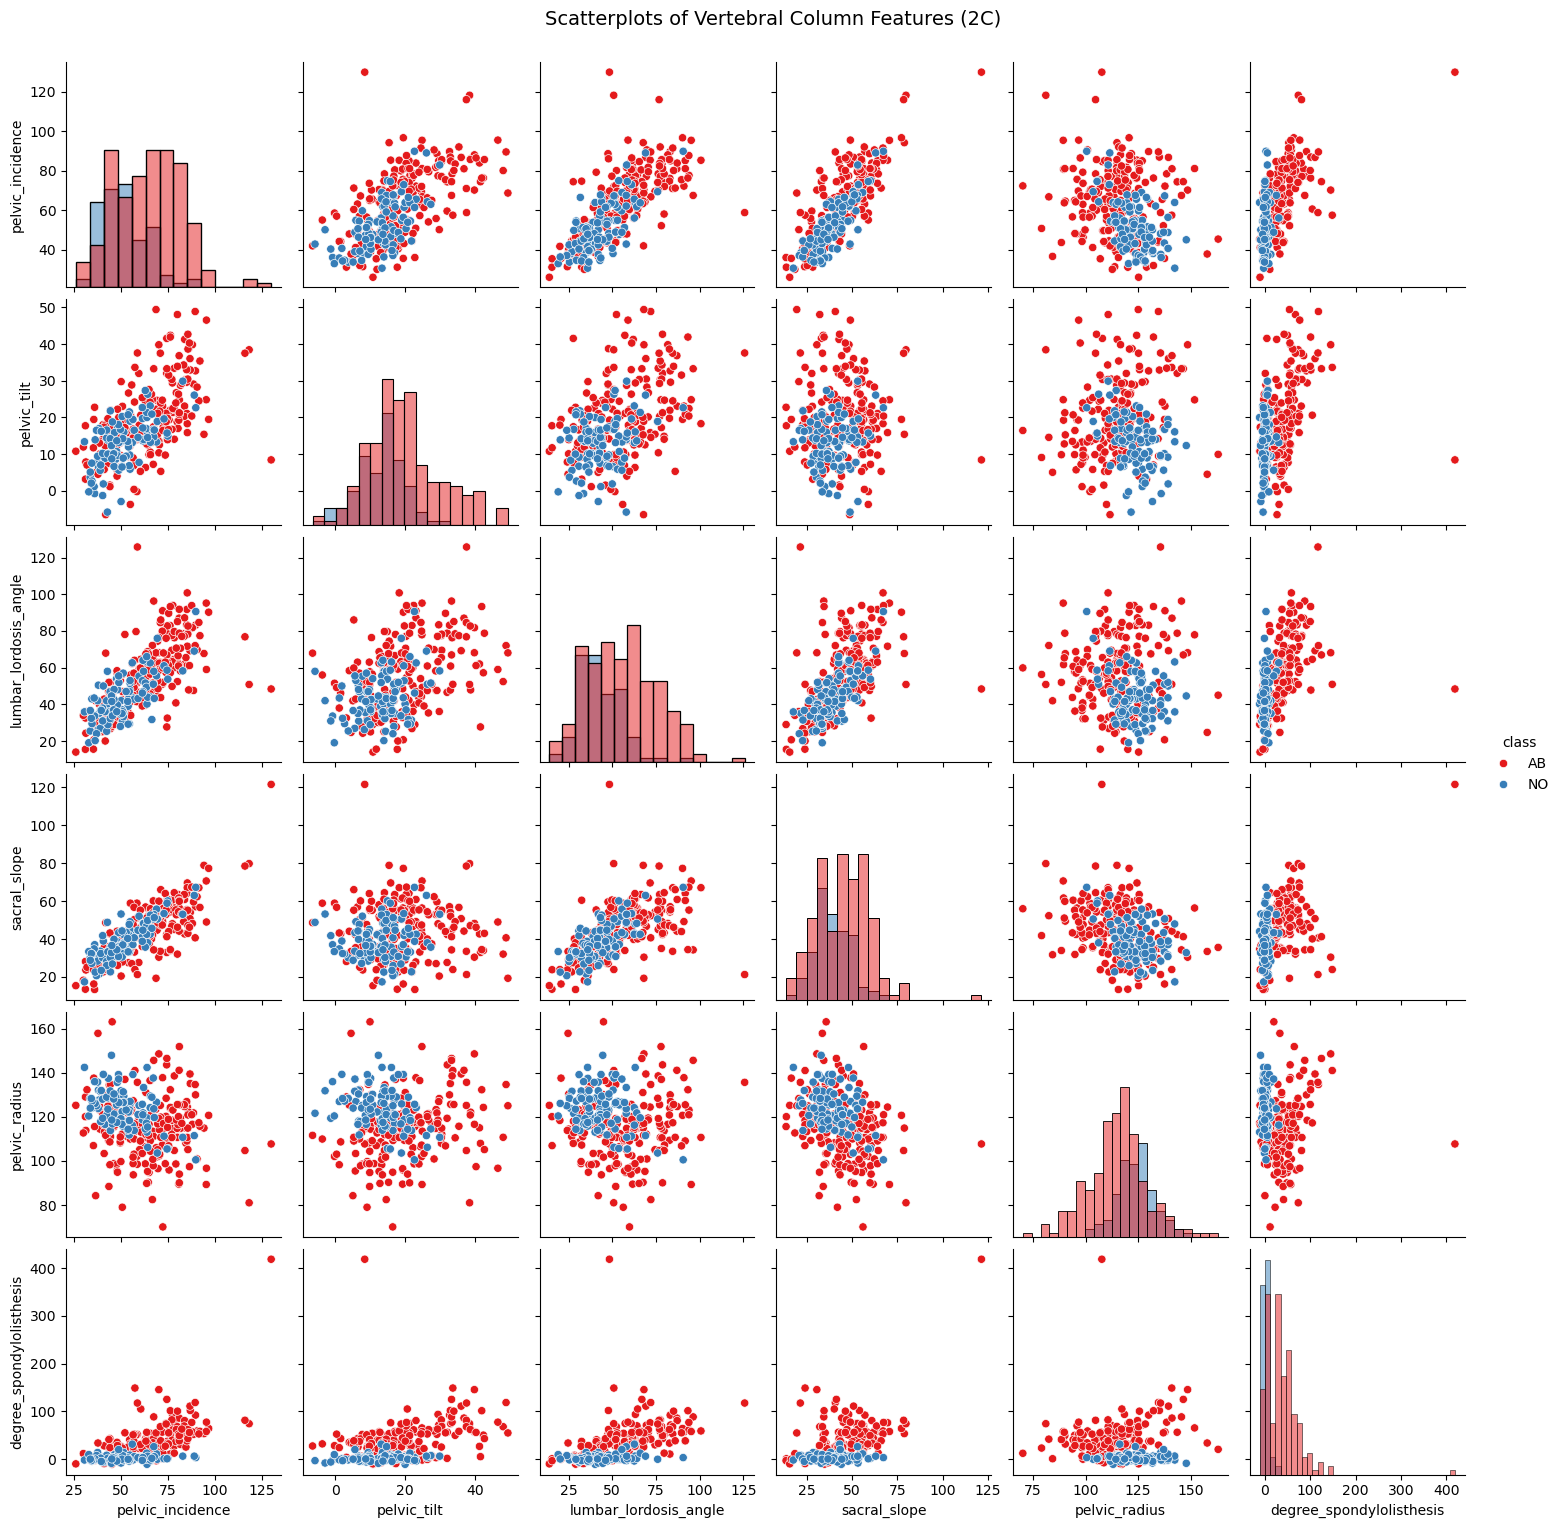

In [60]:
sns.pairplot(
    data_2c,
    vars=[
        "pelvic_incidence",
        "pelvic_tilt",
        "lumbar_lordosis_angle",
        "sacral_slope",
        "pelvic_radius",
        "degree_spondylolisthesis"
    ],
    hue="class",        
    diag_kind="hist",   
    palette="Set1"      
)

plt.suptitle("Scatterplots of Vertebral Column Features (2C)", y=1.02, fontsize=14)
plt.show()


#### ii. Boxplots

Use different colors to distinguish between category 0 and category 1, and draw box plots for each independent variable.

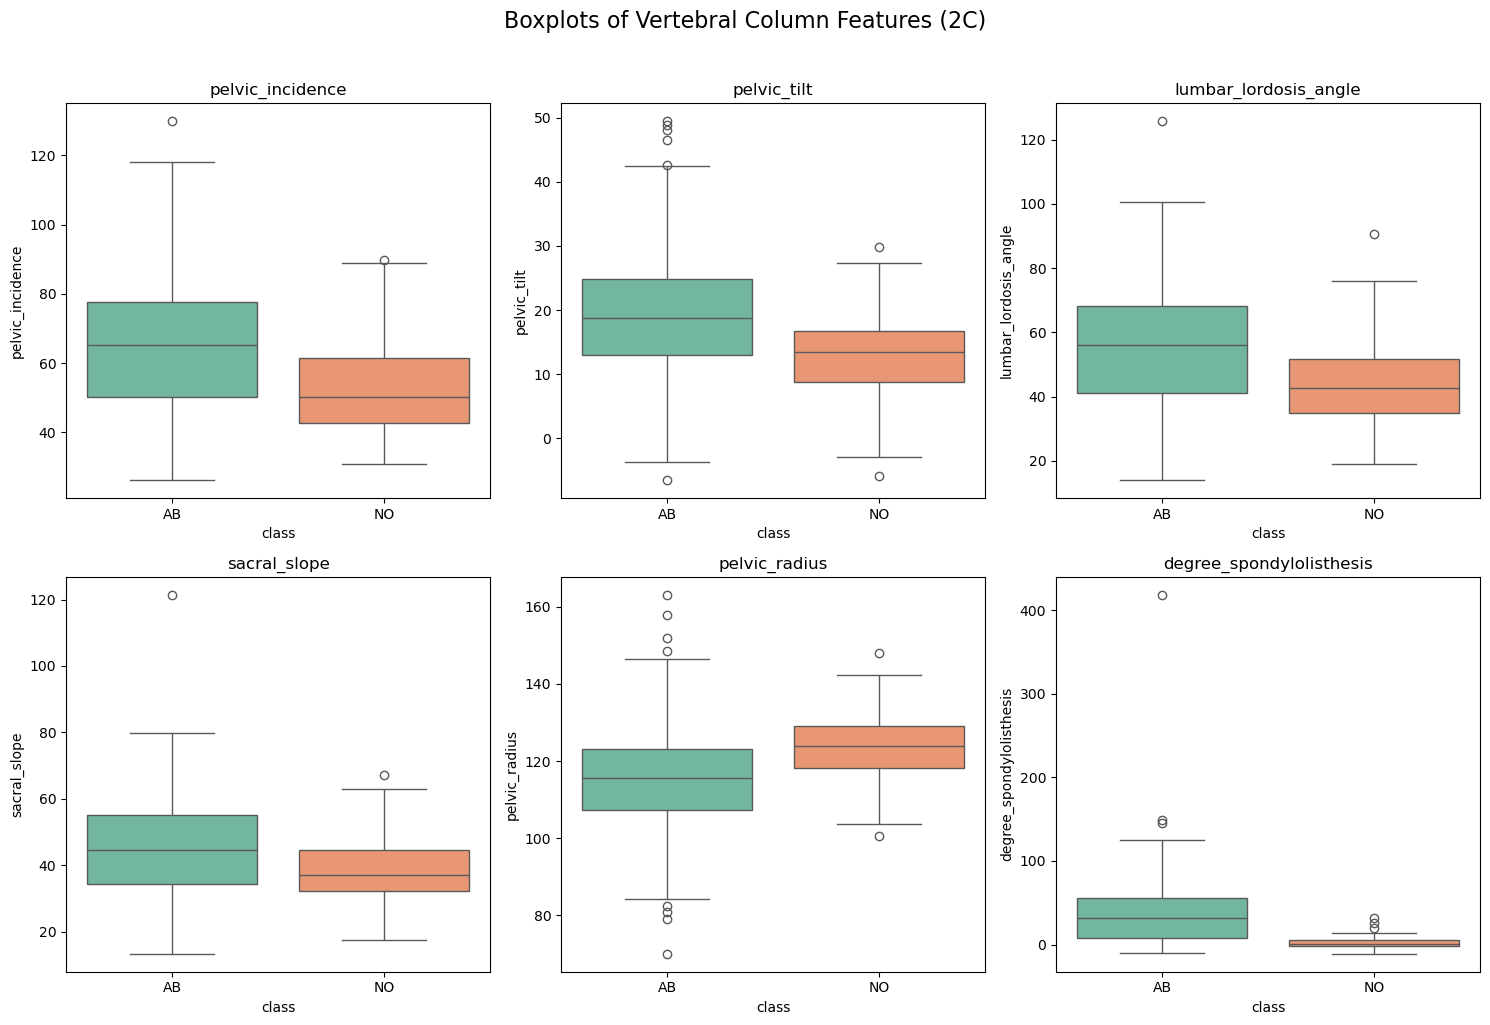

In [64]:
features = [
    "pelvic_incidence",
    "pelvic_tilt",
    "lumbar_lordosis_angle",
    "sacral_slope",
    "pelvic_radius",
    "degree_spondylolisthesis"
]

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)  
    sns.boxplot(
        x="class",
        y=feature,
        data=data_2c,
        hue="class",          
        palette="Set2",
        legend=False
    )
    plt.title(feature)

plt.suptitle("Boxplots of Vertebral Column Features (2C)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


#### iii. Split Data Set

Select the first 70 rows of Class 0 and the first 140 rows of Class 1 as the training set and the rest of the data as the test set.

In [86]:
data_2c = data_2c.dropna(axis=1, how="all")
data_3c = data_3c.dropna(axis=1, how="all")
data_2c = data_2c.iloc[:, :7]
data_3c = data_3c.iloc[:, :7]
cols = [
    "pelvic_incidence","pelvic_tilt","lumbar_lordosis_angle",
    "sacral_slope","pelvic_radius","degree_spondylolisthesis","class"
]
data_2c.columns = cols
data_3c.columns = cols

data_2c["class"] = (
    data_2c["class"].astype(str).str.strip().str.upper().map({"NO":0, "AB":1, "0":0, "1":1})
)

class0 = data_2c[data_2c["class"] == 0]
class1 = data_2c[data_2c["class"] == 1]

train_class0 = class0.iloc[:70]
train_class1 = class1.iloc[:140]
train_data = pd.concat([train_class0, train_class1])
test_data  = pd.concat([class0.iloc[70:], class1.iloc[140:]])

features = cols[:-1]
X_train, y_train = train_data[features], train_data["class"]
X_test,  y_test  = test_data[features],  test_data["class"]

print("The size of the test set:", X_train.shape, y_train.shape)
print("The size of the test set:", X_test.shape,  y_test.shape)
print("Training set distribution:\n", y_train.value_counts())
print("Training set distribution:\n",  y_test.value_counts())


The size of the test set: (210, 6) (210,)
The size of the test set: (100, 6) (100,)
Training set distribution:
 class
1    140
0     70
Name: count, dtype: int64
Training set distribution:
 class
1    70
0    30
Name: count, dtype: int64


### (c) Classification

#### i. Euclidean Metric

The k-nearest neighbor algorithm using Euclidean distance measurement.Based on the k value (k ∈ {208, 205, ... , 7, 4, 1}, arranged in descending order), a chart of training error and test error is drawn. It is found that k = 4 is the most suitable.

Best k* = 4 | Test error = 0.0600 | Train error = 0.1429


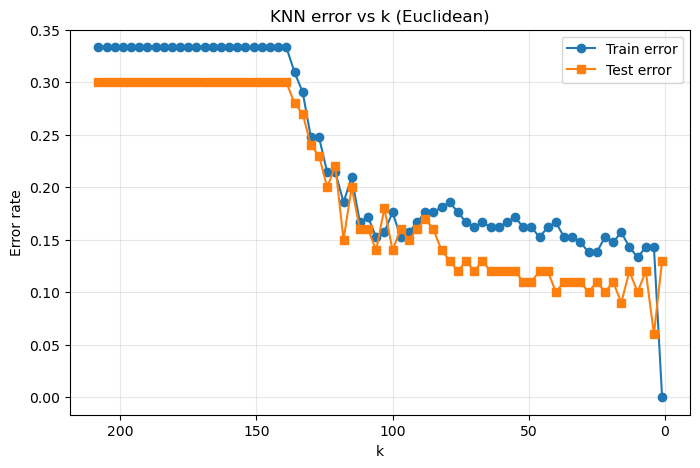

In [94]:
k_values = list(range(208, 0, -3))
k_values = [k for k in k_values if k <= len(X_train)] 

train_err, test_err = [], []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train, y_train)
    tr_pred = knn.predict(X_train)
    te_pred = knn.predict(X_test)
    train_err.append(1 - (tr_pred == y_train).mean())
    test_err.append(1 - (te_pred == y_test).mean())

best_idx = int(np.argmin(test_err))
k_star = k_values[best_idx]
print(f"Best k* = {k_star} | Test error = {test_err[best_idx]:.4f} | Train error = {train_err[best_idx]:.4f}")


plt.figure(figsize=(8,5))
plt.plot(k_values, train_err, marker='o', label='Train error')
plt.plot(k_values, test_err, marker='s', label='Test error')
plt.gca().invert_xaxis()  
plt.xlabel('k')
plt.ylabel('Error rate')
plt.title('KNN error vs k (Euclidean)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


#### ii. Test Data

When k = 4, calculate the confusion matrix, true positive rate, true negative rate, precision rate and F1 score.

In [152]:
k_half = max(1, k_star // 2)
print("Evaluating at k*//2 =", k_half)

knn_half = KNeighborsClassifier(n_neighbors=k_half, metric='euclidean')
knn_half.fit(X_train, y_train)
y_pred_half = knn_half.predict(X_test)

cm = confusion_matrix(y_test, y_pred_half, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

tpr = tp / (tp + fn) if (tp + fn) else 0.0
tnr = tn / (tn + fp) if (tn + fp) else 0.0
precision = precision_score(y_test, y_pred_half, pos_label=1, zero_division=0)
f1 = f1_score(y_test, y_pred_half, pos_label=1, zero_division=0)

print("Confusion Matrix (rows=true, cols=pred; order=[0,1]):")
print(cm)
print(f"TPR (Recall, class=1): {tpr:.4f}")
print(f"TNR (Specificity, class=0): {tnr:.4f}")
print(f"Precision (class=1): {precision:.4f}")
print(f"F1-score (class=1): {f1:.4f}")


Evaluating at k*//2 = 2
Confusion Matrix (rows=true, cols=pred; order=[0,1]):
[[25  5]
 [ 5 65]]
TPR (Recall, class=1): 0.9286
TNR (Specificity, class=0): 0.8333
Precision (class=1): 0.9286
F1-score (class=1): 0.9286


#### iii. Learning Curve

Train KNN on training sets of different sizes (from 10 to 210), select the optimal k for each size, and plot the curve of the best test error rate as the training set size changes.

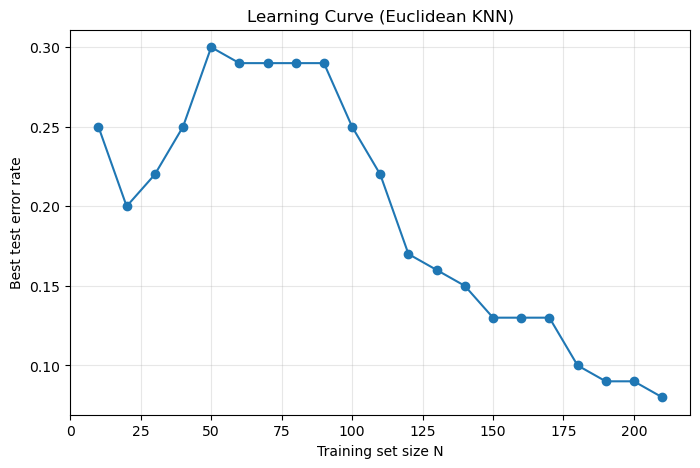

In [102]:
train_c0 = train_data[train_data["class"] == 0]
train_c1 = train_data[train_data["class"] == 1]

N_list = list(range(10, 211, 10))
best_test_err_per_N = []

for N in N_list:
    n0 = N // 3
    n1 = N - n0
    n0 = min(n0, len(train_c0))
    n1 = min(n1, len(train_c1))
    sub_train = pd.concat([train_c0.iloc[:n0], train_c1.iloc[:n1]])
    Xtr, ytr = sub_train[features], sub_train["class"]
    Xte, yte = X_test, y_test
    k_grid = list(range(1, len(sub_train)+1, 5))
    k_grid = [k for k in k_grid if k <= len(sub_train)]
    
    errs = []
    for k in k_grid:
        knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        knn.fit(Xtr, ytr)
        err = 1 - (knn.predict(Xte) == yte).mean()
        errs.append(err)
    
    best_err = min(errs)
    best_test_err_per_N.append(best_err)

plt.figure(figsize=(8,5))
plt.plot(N_list, best_test_err_per_N, marker='o')
plt.xlabel('Training set size N')
plt.ylabel('Best test error rate')
plt.title('Learning Curve (Euclidean KNN)')
plt.grid(True, alpha=0.3)
plt.show()


### (d) Other Metrics

#### i. Minkowski Distance.

By replacing the Euclidean distance in KNN with other distance metrics (Manhattan distance, general Minkowski distance, Chebyshev distance), and searching for the optimal parameters within the given k value range, the classification performance under different distance metrics was compared.

In [213]:
k_grid = list(range(1, len(X_train)+1, 5))  
errs = []

for k in k_grid:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=1)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    err = 1 - (pred == y_test).mean()
    errs.append(err)

errs = np.array(errs)
min_err = errs.min()
best_ks = [k for k, e in zip(k_grid, errs) if np.isclose(e, min_err)]

print(f"Best Manhattan (p=1): k values={best_ks}, Test error={min_err:.4f}")


Best Manhattan (p=1): k values=[6, 11, 26], Test error=0.1100


##### B. With log10(p) in {0.1, 0.2, 0.3, ... ,1}.

In [106]:
p_values = [10**x for x in np.arange(0.1, 1.01, 0.1)]
errs_p = []

for p in p_values:
    knn = KNeighborsClassifier(n_neighbors=best_k_manhattan, metric='minkowski', p=p)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    err = 1 - (pred == y_test).mean()
    errs_p.append(err)

best_idx = np.argmin(errs_p)
best_p = p_values[best_idx]
print("Best p (Minkowski, log10(p) ∈ [0.1,1]):", best_p, "Test error:", errs_p[best_idx])


Best p (Minkowski, log10(p) ∈ [0.1,1]): 3.981071705534973 Test error: 0.06000000000000005


##### C. Chebyshev Distance With p -> infinity.

In [108]:
errs = []
for k in k_grid:
    knn = KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    err = 1 - (pred == y_test).mean()
    errs.append(err)

best_idx = np.argmin(errs)
best_k_chebyshev = k_grid[best_idx]
best_err_chebyshev = errs[best_idx]

print(f"Best Chebyshev: k={best_k_chebyshev}, Test error={best_err_chebyshev:.4f}")


Best Chebyshev: k=16, Test error=0.0800


#### ii. Mahalanobis Distance.

In [184]:
V = np.cov(X_train, rowvar=False)
VI = inv(V)
k_grid = list(range(1, min(196, len(X_train)) + 1, 5))
errs = []

for k in k_grid:
    knn = KNeighborsClassifier(
        n_neighbors=k,
        metric='mahalanobis',
        metric_params={'VI': VI}  
    )
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    err = 1 - (pred == y_test).mean()
    errs.append(err)

best_idx = int(np.argmin(errs))
best_k_mahal = k_grid[best_idx]
best_err_mahal = errs[best_idx]

print(f"Best Mahalanobis: k={best_k_mahal}, Test error={best_err_mahal:.4f}")

Best Mahalanobis: k=1, Test error=0.1700


### (e) Weighted Decision

By replacing the majority voting decision of KNN with weighted voting (where the influence of neighbors on the prediction is inversely proportional to their distance), the classification performance under different distance metrics (Euclidean, Manhattan, Chebyshev) was examined. Within the given set of k values {1, 6, 11, ..., 196}, the optimal k value that minimizes the test error rate for each distance metric was found, and the corresponding best test error rate was reported. This enabled a comparison of whether weighted voting can improve classification performance compared to majority voting, as well as the impact of different distance metrics on the results.

In [126]:
metrics = {
    "Euclidean": {"metric": "euclidean"},
    "Manhattan": {"metric": "minkowski", "p": 1},
    "Chebyshev": {"metric": "chebyshev"}
}

k_grid = list(range(1, 197, 5))  
results_weighted = []

for name, params in metrics.items():
    best_err = float("inf")
    best_k = None
    for k in k_grid:
        knn = KNeighborsClassifier(
            n_neighbors=k,
            weights='distance',   
            **params
        )
        knn.fit(X_train, y_train)
        pred = knn.predict(X_test)
        err = 1 - (pred == y_test).mean()
        if err < best_err:
            best_err = err
            best_k = k
    results_weighted.append((name, best_k, best_err))

df_weighted = pd.DataFrame(results_weighted, columns=["Metric", "Best k", "Test Error"])
print(df_weighted)


      Metric  Best k  Test Error
0  Euclidean       6        0.10
1  Manhattan      26        0.10
2  Chebyshev      16        0.11


### (f) Training Error Rate

In [211]:
# —— 定义度量（把 p 放到 __init__，metric_params 只给 Mahalanobis）——
metric_configs = [
    ("Euclidean",   {"metric": "euclidean",  "init": {},          "metric_params": {}}),
    ("Manhattan",   {"metric": "minkowski",  "init": {"p": 1},    "metric_params": {}}),
    ("Chebyshev",   {"metric": "chebyshev",  "init": {},          "metric_params": {}}),
    ("Mahalanobis", {"metric": "mahalanobis","init": {},          "metric_params": {"VI": VI}}),
]

# —— (f) 仅训练误差最小化（表观误差）——
n_train = len(X_train)
k_grid = list(range(1, min(196, n_train) + 1, 5))

records = []
best_overall = {"Metric": None, "Voting": None, "k": None, "Train Error": float("inf")}

for name, cfg in metric_configs:
    for vname, w in [("Majority","uniform"), ("Weighted","distance")]:
        best_err, best_k = float("inf"), None
        for k in k_grid:
            knn = KNeighborsClassifier(
                n_neighbors=k, weights=w,
                metric=cfg["metric"],
                **cfg["init"],                   # p 在这里
                metric_params=cfg["metric_params"]  # 仅 Mahalanobis 用到
            )
            knn.fit(X_train, y_train)
            err_tr = 1 - (knn.predict(X_train) == y_train).mean()
            if err_tr < best_err or (np.isclose(err_tr, best_err) and (best_k is None or k < best_k)):
                best_err, best_k = err_tr, k
            if err_tr < best_overall["Train Error"] or (
                np.isclose(err_tr, best_overall["Train Error"]) and (best_overall["k"] is None or k < best_overall["k"])
            ):
                best_overall.update({"Metric": name, "Voting": vname, "k": k, "Train Error": err_tr})
        records.append([name, vname, best_k, best_err])

import pandas as pd
df_app = pd.DataFrame(records, columns=["Metric","Voting","Best k (Train)","Min Train Error"])
print("\n Apparent training error (no self-exclusion) ")
print(df_app.sort_values(["Min Train Error","Metric","Voting"]).to_string(index=False))

print("\n Lowest training error across ALL experiments (apparent) ")
print(f"Metric: {best_overall['Metric']}, Voting: {best_overall['Voting']}, "
      f"k = {best_overall['k']}, Lowest Train Error = {best_overall['Train Error']*100:.2f}%")



 Apparent training error (no self-exclusion) 
     Metric   Voting  Best k (Train)  Min Train Error
  Chebyshev Majority               1              0.0
  Chebyshev Weighted               1              0.0
  Euclidean Majority               1              0.0
  Euclidean Weighted               1              0.0
Mahalanobis Majority               1              0.0
Mahalanobis Weighted               1              0.0
  Manhattan Majority               1              0.0
  Manhattan Weighted               1              0.0

 Lowest training error across ALL experiments (apparent) 
Metric: Euclidean, Voting: Majority, k = 1, Lowest Train Error = 0.00%


In this assignment, the lowest observed training error was 0%, which was achieved when k = 1, using all distance metrics (Euclidean, Manhattan, Chebyshev, and Mahalanobis distances), as well as both majority voting and weighted voting methods. This indicates that in this case, the classifier perfectly fit the training data, as each training point was its own nearest neighbor.